In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
path1 = "/content/gdrive/MyDrive/Train/diseased"

In [4]:
path2 = "/content/gdrive/MyDrive/Train/healthy"

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import cv2
import glob
from PIL import Image
import pandas as pd
import torch.nn.functional as Func
from torch.utils.data import Dataset

In [6]:
import os
train = []
test = []
l = [0,0]

c = 0

for filename in os.listdir(path1):
  filename = path1 + "/" + filename
  if c > 564:
    l[0] = 1
    test.append([filename,l])
    c += 1
  else:
    l[0] = 1
    train.append([filename,l])
    c += 1

In [7]:
import os
l = [0,0]

c = 0

for filename in os.listdir(path2):
  filename = path2 + "/" + filename
  if c > 654:
    l[1] = 1
    test.append([filename,l])
    c += 1
  else:
    l[1] = 1
    train.append([filename,l])
    c += 1

In [8]:
class Dataset(Dataset):
    

    def __init__(self, train, root_dir, transform=None):
        
        self.landmarks_frame = train
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,self.landmarks_frame[idx][0])
        image = cv2.imread(img_name)
        y = torch.tensor(self.landmarks_frame[idx][1])
        y = y.float()
        
        

        if self.transform:
            image = self.transform(image)

        return (image,y)

In [9]:
print(len(train))

1220


In [10]:
print(len(test))

519


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
train_dataset = Dataset(train = train,root_dir='', transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

]))

In [13]:
test_dataset = Dataset(train = test,root_dir='', transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

]))

In [14]:
num_classes = 2
batch_size = 8
num_epochs = 20

In [15]:
trainloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

testloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [16]:
class ConvNet_SGD(nn.Module):
    def __init__(self):
        super(ConvNet_SGD, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.pool2 = nn.MaxPool2d(3,3)
        self.conv2 = nn.Conv2d(6, 10, 4)
        self.conv3 = nn.Conv2d(10,20, 4)
        self.fc1 = nn.Linear(20*4*4, 120)
        self.fc2 = nn.Linear(120, 10)
        self.fc3= nn.Linear(10,2)
 

    def forward(self, x):

        x = self.pool(self.conv1(x))  
        x = self.pool(self.conv2(x))  
        x=  self.pool2(self.conv3(x))
        x = x.view(-1, 20*4*4)           
        x = Func.relu(self.fc1(x))              
        x = self.fc2(x)         
        x = self.fc3(x)    
        return x

In [17]:
model=ConvNet_SGD().to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
num_epochs=20

In [19]:
losses = []

In [20]:
def train_model(model):

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()
        running_loss = 0.0

        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
 

 
            optimizer.zero_grad()


            with torch.set_grad_enabled(True):
            
              outputs = model(inputs)
    
              loss = criterion(outputs, labels)

              _, preds = torch.max(outputs, 1)
              loss.backward()
              optimizer.step()


            running_loss += loss.item() * inputs.size(0)
              

        epoch_loss = running_loss / len(trainloader.dataset)
        print('Loss: {:.4f} '.format(epoch_loss))
        losses.append(epoch_loss)

In [21]:
train_model(model)

Epoch 0/9
----------
Loss: 0.6841 
Epoch 1/9
----------
Loss: 0.5196 
Epoch 2/9
----------
Loss: 0.3340 
Epoch 3/9
----------
Loss: 0.2516 
Epoch 4/9
----------
Loss: 0.2185 
Epoch 5/9
----------
Loss: 0.1729 
Epoch 6/9
----------
Loss: 0.1402 
Epoch 7/9
----------
Loss: 0.1399 
Epoch 8/9
----------
Loss: 0.1176 
Epoch 9/9
----------
Loss: 0.1301 


In [4]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Number of Epochs')

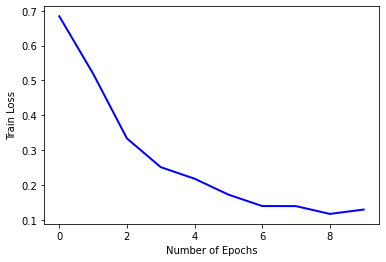

In [6]:
plt.plot( losses,color='blue', label= "Train_Loss", linewidth=2)
plt.ylabel('Train Loss')
plt.xlabel('Number of Epochs')

In [22]:
Predicted = []
Lab = []

In [23]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:

        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)


        _, predicted = torch.max(outputs, 1)

        _, lab = torch.max(labels , 1)
        for x in range(len(predicted)):
          Predicted.append(int(predicted[x]))
          Lab.append(int(lab[x]))

        total += labels.size(0)
        correct += (predicted == lab).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 93 %


In [24]:
from sklearn.metrics import classification_report
y_true = Lab
y_pred = Predicted
target_names = ['class' + str(x) for x in range(2)]
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      class0       0.91      0.96      0.93       240
      class1       0.96      0.92      0.94       279

    accuracy                           0.94       519
   macro avg       0.94      0.94      0.94       519
weighted avg       0.94      0.94      0.94       519

